# **Project Goal**

The goal of this project is to use **SQL, Python, Pandas (some Numpy), and Matplotlib** to analyze unemployment and wage data across college majors.  
By combining a national unemployment *Federal Reserve Bank of St. Louis* dataset (fred), with a *Federal Reserve Bank of New York*(major)  dataset of unemployment and wage outcomes by major, and many others, where the analysis explores:  

- How unemployment rates differ across majors  
- How **Computer Science** compare to other majors in both unemployment and wages  
- How major-level unemployment compares against national unemployment trends (2019–2025)  
- Whether there is any correlation between unemployment rates and wages (early-career and mid-career)  

The objective is to provide clear visual and statistical insights into where technical majors stand in terms of **risk (unemployment)** and **reward (wages)**, both relative to each other and to the broader U.S. labor market.  


## Setup  

First, import the core Python packages required for this analysis:  

- **pandas** → for reading, cleaning, and querying tabular data  
- **matplotlib** → for creating visualizations  
- **numpy** → for numerical analysis and regression  
- **sqlalchemy** → for connecting to and querying the SQLite database

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

## Load the Datasets  

We will be working with two datasets:  

- **FRED (Federal Reserve Economic Data):** Contains U.S. unemployment rates over time.  
- **Major Unemployment Dataset:** Contains unemployment rates, underemployment, and wage outcomes across college majors.  

Both datasets were cleaned from their original Excel files and saved as CSVs.  
We’ll load them into Pandas DataFrames, naming them `fred` and `major_unem`.  

To quickly verify the structure and columns of each dataset, we’ll use the `.head()` function to preview the first few rows.


In [185]:
fred = pd.read_csv("/home/rroscoe51/DataAnalysisProj/Data/FRED_Data.csv", encoding="utf-8-sig")
print(fred.head())

      Monthly  Unemployment Rate
0  2019-01-01                4.0
1  2019-02-01                3.8
2  2019-03-01                3.8
3  2019-04-01                3.7
4  2019-05-01                3.6


In [186]:
major_unem = pd.read_csv("/home/rroscoe51/DataAnalysisProj/Data/Major_Unemployment.csv", encoding="utf-8-sig")
print(major_unem.head())

                       Major  Unemployment Rate  Underemployment Rate  \
0                Agriculture                1.2                  42.4   
1  Animal and Plant Sciences                1.0                  53.2   
2      Environmental Studies                2.6                  49.0   
3               Architecture                4.3                  30.8   
4             Ethnic Studies                2.6                  47.7   

  Median Wage Early Career Median Wage Mid-Career  Share with Graduate Degree  
0                   50,000                 75,000                        19.9  
1                   43,000                 70,000                        35.6  
2                   46,700                 75,000                        31.2  
3                   52,000                 80,000                        40.8  
4                   45,000                 83,000                        51.3  


## Connect Jupyter with SQLite  

To query our datasets using SQL directly inside the Jupyter notebook, we need to connect Python to SQLite.  
We’ll use two main tools here:  

- **ipython-sql** → a Jupyter extension that lets us run SQL commands in notebook cells using the `%sql` magic.  
- **SQLAlchemy** → Python’s database toolkit that provides an engine to connect and execute SQL queries more cleanly than using `sqlite3` directly.  

This setup allows us to switch between **Python (Pandas/NumPy/Matplotlib)** and **SQL queries** when exploring and analyzing our data.


In [187]:
# Install and load the SQL extension (run once)
%pip install ipython-sql sqlalchemy --quiet
%load_ext sql

# Connect to an on-disk SQLite DB (absolute path)
#%sql sqlite:/home/rroscoe51/DataAnalysisProj/notebooks/.venv/data/majors_unemployment.db
%reload_ext sql

Note: you may need to restart the kernel to use updated packages.
The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Create the Database Engine and Load Data  

Now that our packages and extensions are set up, we’ll create a **SQLAlchemy engine** to act as the bridge between Python and our SQLite database.  

Before inserting the data into SQL tables, we need to clean the **wage columns** from the *Majors dataset*:  

- Both **Median Wage Early Career** and **Median Wage Mid-Career** were stored as strings with commas (e.g., `"80,000"`).  
- SQL (and Pandas numeric operations) can’t properly sort or calculate with these string values.  
- We’ll remove the commas and convert these columns into integers for proper numerical analysis.  

Finally, we’ll load both datasets into the database as SQL tables (`majors` and `fred`) and confirm they were successfully created.


In [188]:
# Load CSVs and write them as SQL tables (run once)

engine = create_engine('sqlite:////home/rroscoe51/DataAnalysisProj/notebooks/.venv/data/majors_unemployment.db')

maj = pd.read_csv('/home/rroscoe51/DataAnalysisProj/Data/Major_Unemployment.csv', encoding='utf-8-sig')

"""BELOW IS VITAL as beforehand I was having issues sorting due to the csv data being read in as strings with commas.
Below code replaces comma in string columns, so that it is an easy conversion from string to int for all values"""

for col in ["Median Wage Early Career", "Median Wage Mid-Career"]:
    maj[col] = maj[col].replace({",": ""}, regex=True).astype(int)
fred = pd.read_csv('/home/rroscoe51/DataAnalysisProj/Data/FRED_Data.csv', encoding='utf-8-sig')

maj.to_sql('majors', engine, if_exists='replace', index=False)
fred.to_sql('fred', engine, if_exists='replace', index=False)

print('Tables:', pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", engine))

Tables:      name
0  majors
1    fred


I prefer to fully understand the typing and names of all my columns, so I first printed out the table info of the dataset we will be evaluating for essentially the first half of this project.

In [206]:
print(pd.read_sql("PRAGMA table_info(majors);", engine))

   cid                        name    type  notnull dflt_value  pk
0    0                       Major    TEXT        0       None   0
1    1           Unemployment Rate   FLOAT        0       None   0
2    2        Underemployment Rate   FLOAT        0       None   0
3    3    Median Wage Early Career  BIGINT        0       None   0
4    4      Median Wage Mid-Career  BIGINT        0       None   0
5    5  Share with Graduate Degree   FLOAT        0       None   0


## Observing Majors vs. Unemployment Rate  

Next, we’ll run a simple SQL query to select each **major** and its corresponding **unemployment rate** from the `majors` table.  

Note: Since the column name contains a space (`Unemployment Rate`), we need to wrap it in square brackets (`[Unemployment Rate]`) for the query to work in SQLite.  

We’ll load the result into a Pandas DataFrame (`majors_df`) so it can be used easily in Python for further filtering, sorting, and visualization.


In [207]:
#lets just observe Major vs Unemployment Rate, (had to use brackets bc sql doesn't enjoy spaces in strings)
majors_df = pd.read_sql("""SELECT Major, [Unemployment rate] FROM majors""", engine)
print(majors_df)
#read in as a panda series, useful for later

                        Major  Unemployment Rate
0                 Agriculture                1.2
1   Animal and Plant Sciences                1.0
2       Environmental Studies                2.6
3                Architecture                4.3
4              Ethnic Studies                2.6
..                        ...                ...
62          Treatment Therapy                3.1
63           General Business                3.7
64                 Accounting                1.9
65        Business Management                4.0
66         Business Analytics                2.4

[67 rows x 2 columns]


## Isolating Computer Science and Sorting Majors by Unemployment Rate  

To focus on **Computer Science**, we’ll filter the `majors_df` DataFrame using a **boolean mask**:  

- `majors_df['Major'].str.contains("Computer Science", case=False)` creates a True/False mask by checking if the string *Computer Science* appears in each row of the `Major` column (case-insensitive).  
- Applying this mask (`majors_df[mask]`) returns only the rows that match, giving us Computer Science’s unemployment data.  

After isolating CS, we’ll sort the full dataset by **Unemployment Rate** in ascending order.  
This will allow us to see how Computer Science compares to other majors and build ranked visualizations later.


In [210]:
#now to isolate CS, understanding we read majors.df as a pandas series, we use a mask [majors_df['Major'], to filter the data set
cs_unemp = majors_df[majors_df['Major'].str.contains("Computer Science", case=False)]
print(cs_unemp)
#then lets sort through the data to create an ascending list of the rates
r_unemployment = majors_df.sort_values(by="Unemployment Rate", ascending=True).reset_index(drop=True)
#create descending lists

               Major  Unemployment Rate
10  Computer Science                6.1


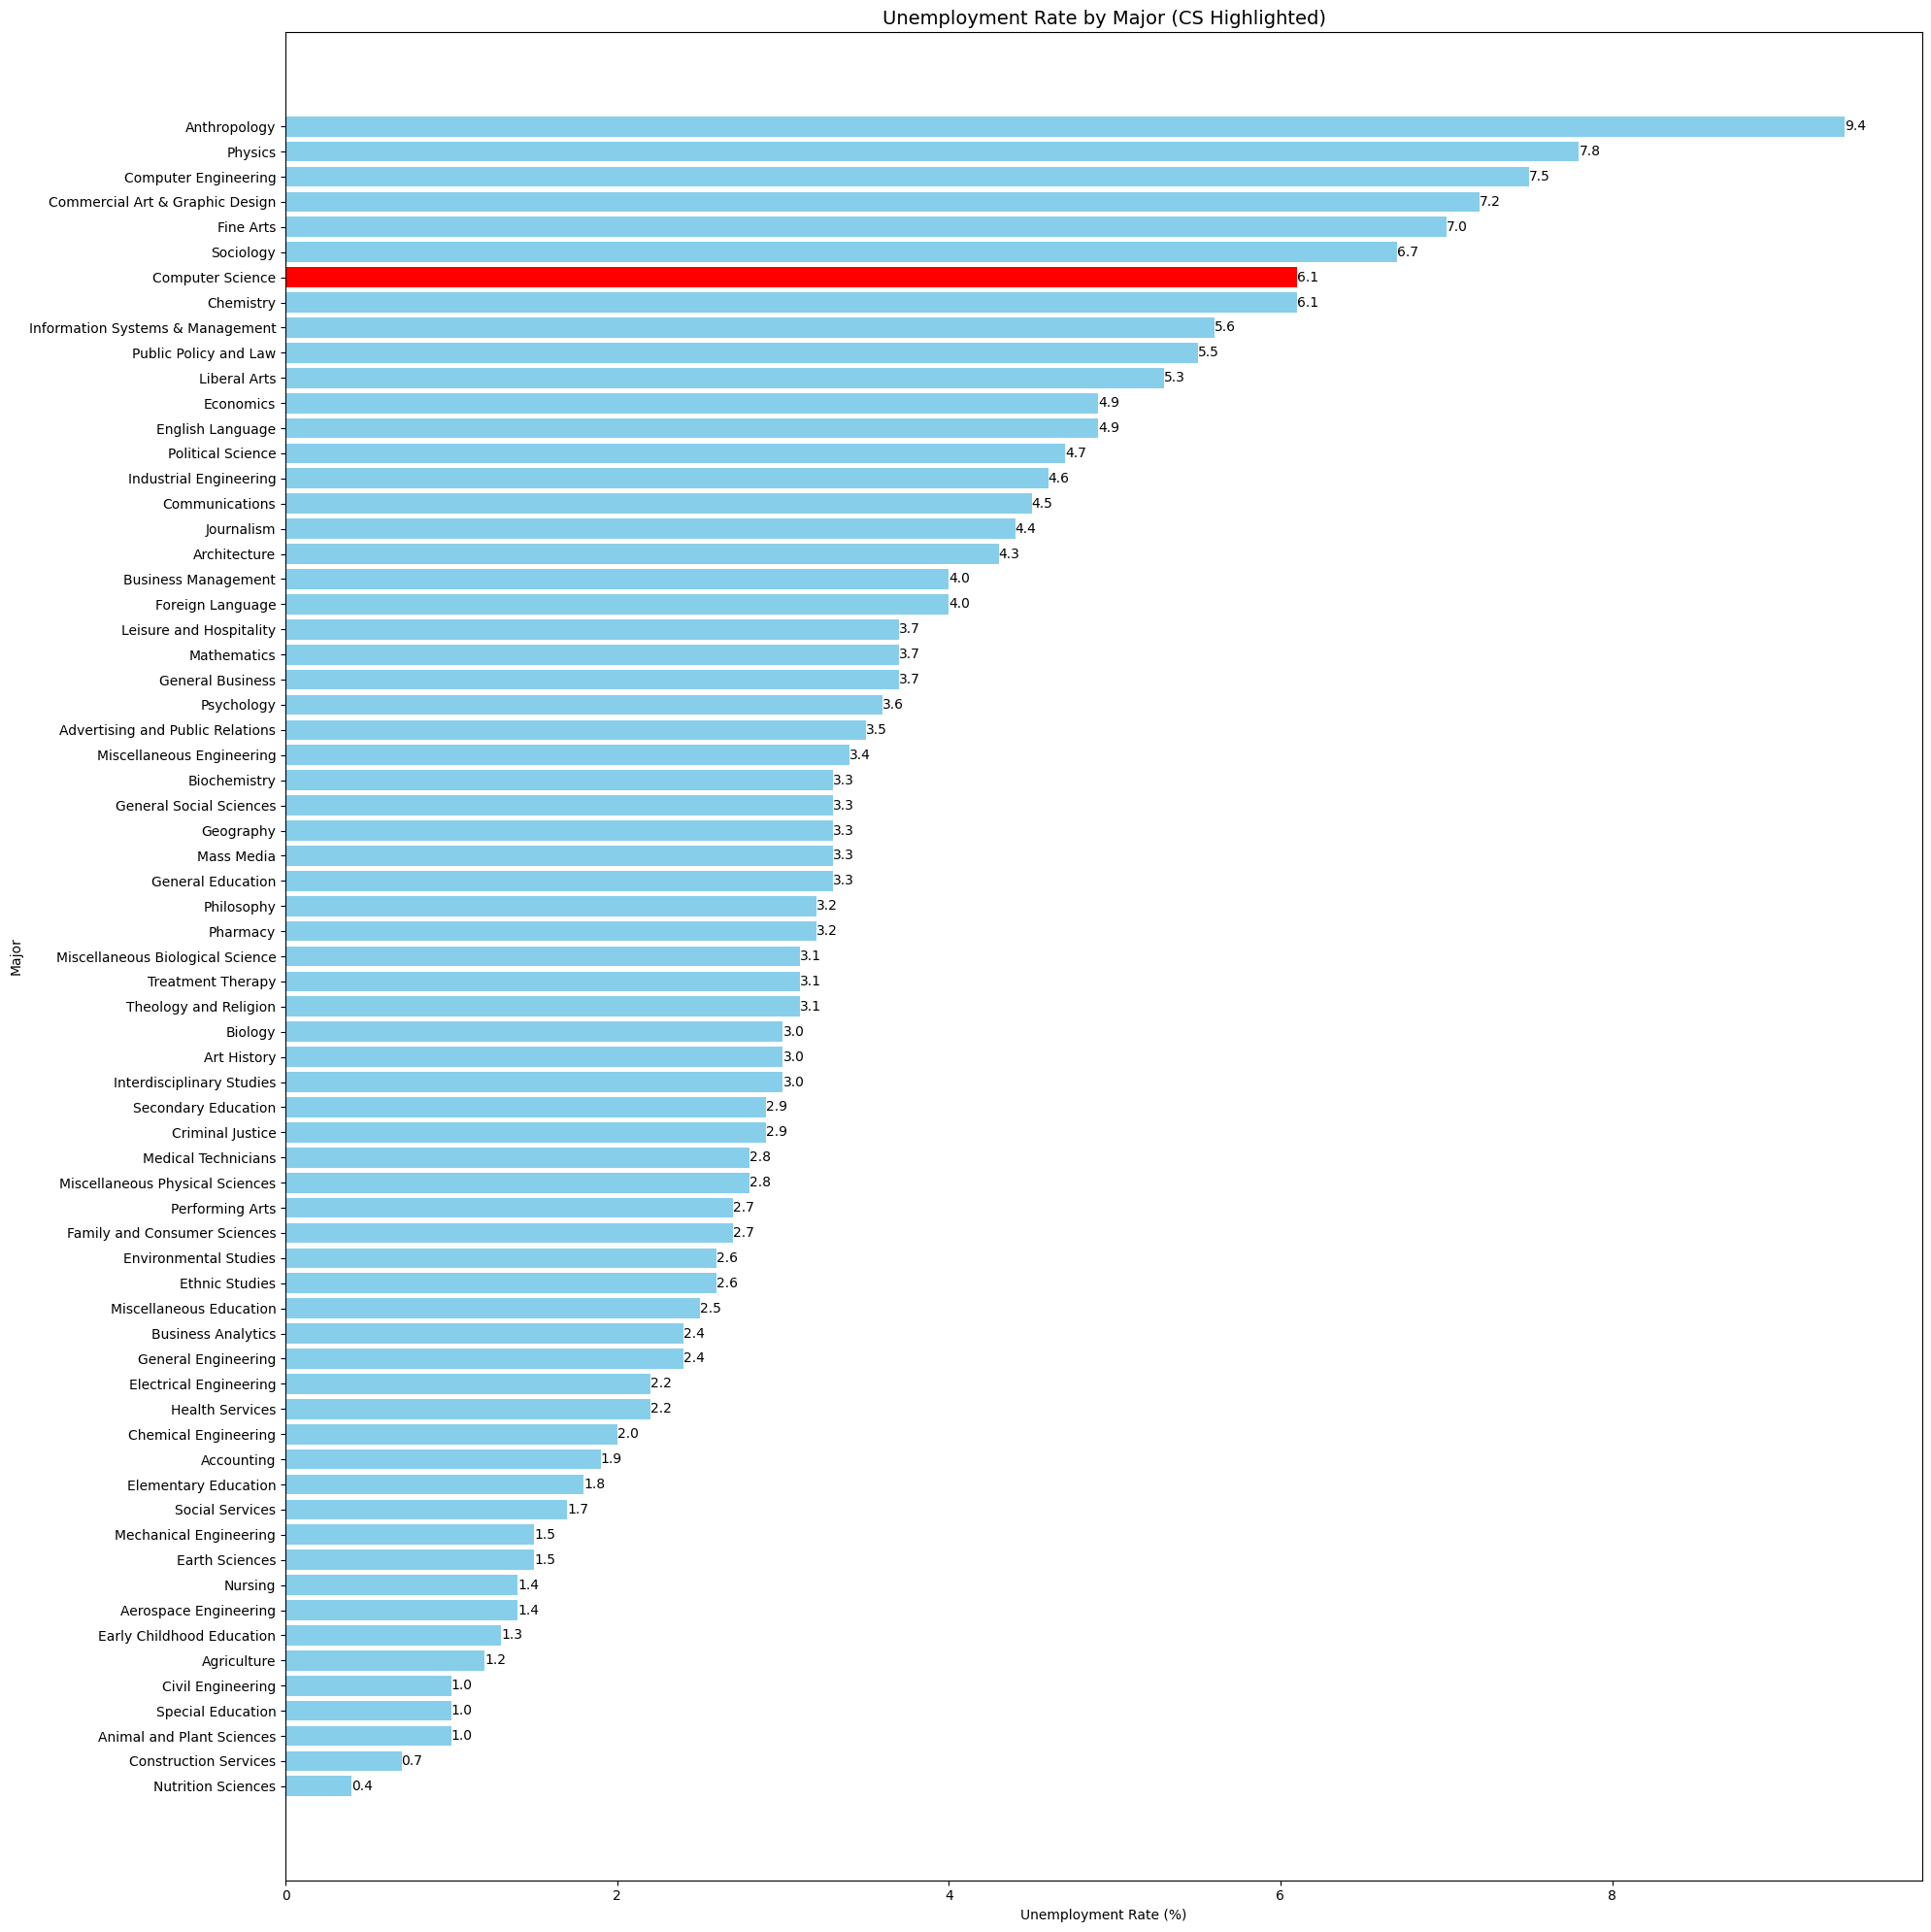

67


In [ ]:
#Build a color list: red for Computer Science, blue for others
colors = ["red" if "Computer Science" in major else "skyblue" for major in r_unemployment["Major"]]

plt.figure(figsize=(20,20))

plt.barh(r_unemployment["Major"], r_unemployment["Unemployment Rate"], color=colors)
bars = plt.barh(r_unemployment["Major"], r_unemployment["Unemployment Rate"], color=colors)
plt.bar_label(bars, fmt="%.1f")  #format with 1 dec
plt.title("Unemployment Rate by Major (CS Highlighted)", fontsize=14)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Major")
plt.tight_layout()
plt.show()
#As we can see COMSCI ranks 7th! Out of 67 majors!
print(len(r_unemployment["Major"]))


## Observations: Computer Science Unemployment  

Computer Science ranks **7th out of 67 majors** for unemployment - a concerning position with a **6.1% unemployment rate**.  

Within the **Michigan State College of Engineering**, this places Computer Science as the **3rd worst major** in terms of unemployment, behind only:  

- **Computer Engineering** (this is sad and hilarious to me).
- **Physics** (the highest unemployment rate among engineering majors. Shocking to me.)




  

It is clear that **Computer Science is objectively risky as a major**, with a relatively high unemployment rate in comparison to most others.  

However, risk often comes with the potential for **high reward**. To evaluate whether this tradeoff holds true, we can examine the **Median Wage Mid-Career** for Computer Science graduates.  

Using SQL, we select the `[Median Wage Mid-Career]` column (taking care to use brackets around the column name due to the space) to measure **earning potential once professionals are established in their careers**.


In [212]:
majors_medianMid = pd.read_sql("""SELECT Major, [Median Wage Mid-Career] FROM majors""", engine)
print(majors_medianMid)
#will give us median wage mid-career from our majors table. printing out just to make sure things look right.

                        Major  Median Wage Mid-Career
0                 Agriculture                   75000
1   Animal and Plant Sciences                   70000
2       Environmental Studies                   75000
3                Architecture                   80000
4              Ethnic Studies                   83000
..                        ...                     ...
62          Treatment Therapy                   80000
63           General Business                   90000
64                 Accounting                   88000
65        Business Management                   80000
66         Business Analytics                  100000

[67 rows x 2 columns]


                        Major  Median Wage Mid-Career
0   Early Childhood Education                   49000
1        Elementary Education                   53000
2             Social Services                   54000
3           Special Education                   55000
4           General Education                   55000
..                        ...                     ...
62           Computer Science                  115000
63     Electrical Engineering                  120000
64       Chemical Engineering                  120000
65       Computer Engineering                  122000
66      Aerospace Engineering                  125000

[67 rows x 2 columns]


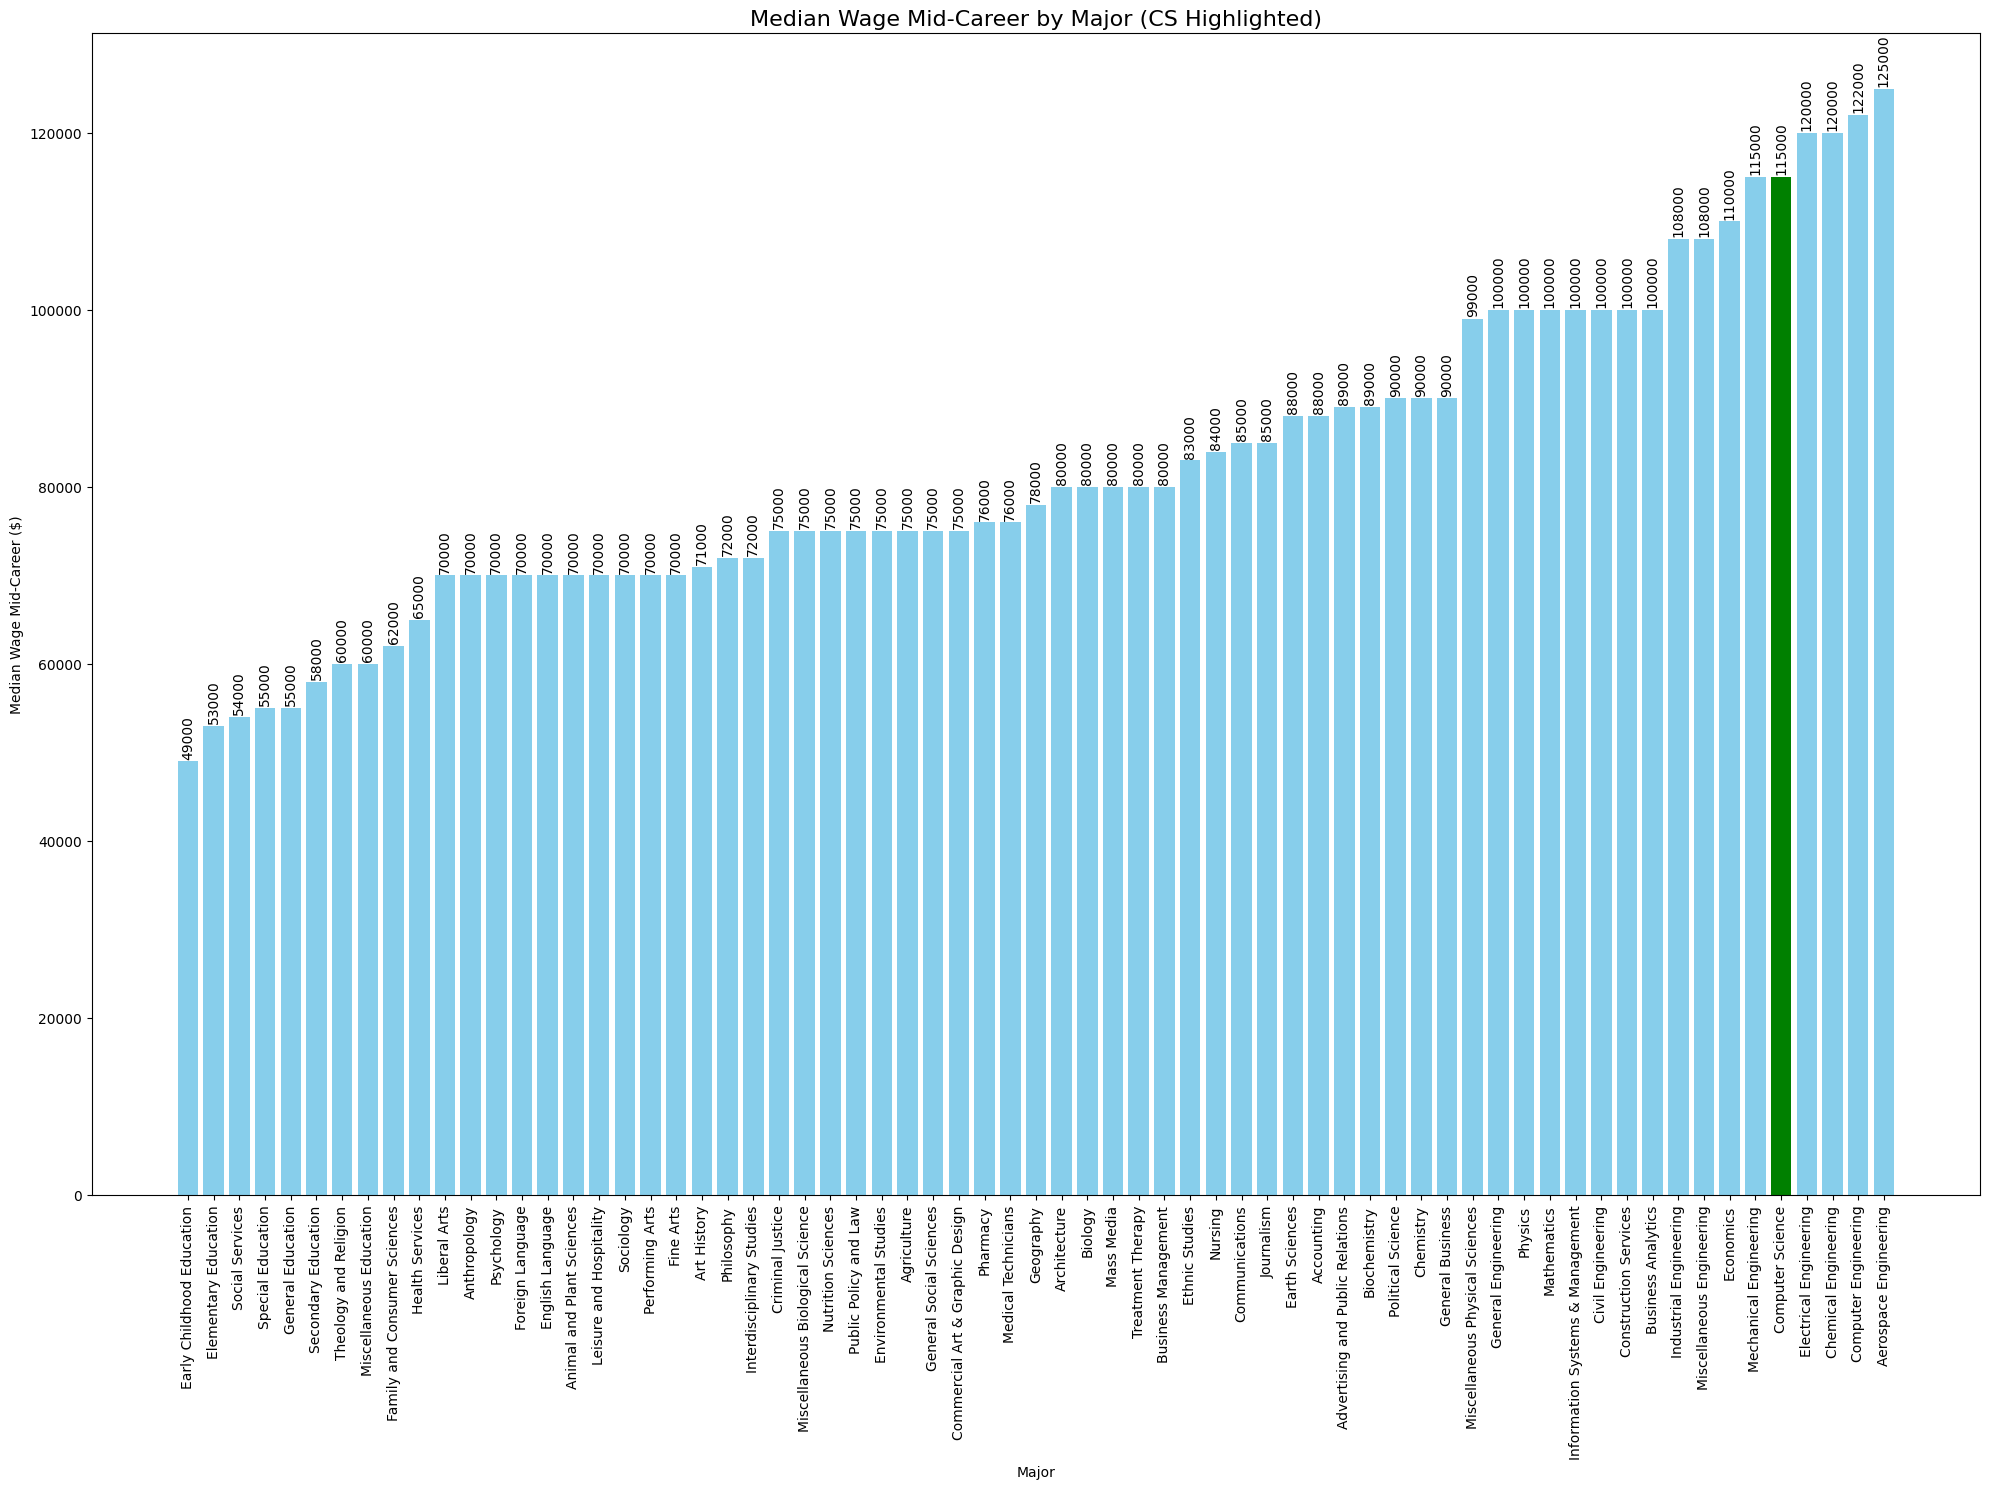

In [215]:


#Need to sot salary values in order to properly and neatly graph them
r_mWmid = majors_medianMid.sort_values(
    by="Median Wage Mid-Career", ascending=True
).reset_index(drop=True)
print(r_mWmid)

#Make sure that computer science stands out. I like blue
colors = ["green" if "Computer Science" in major else "skyblue" 
          for major in r_mWmid["Major"]]

#Make plot look clean, adjust fig size, rotate labels, eliminate space, etc.
plt.figure(figsize=(20, 15))

bars = plt.bar(r_mWmid["Major"], r_mWmid["Median Wage Mid-Career"], color=colors)

plt.bar_label(bars, fmt="%.0f", rotation=90, padding=2)

plt.title("Median Wage Mid-Career by Major (CS Highlighted)", fontsize=16)
plt.ylabel("Median Wage Mid-Career ($)")
plt.xlabel("Major")

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


## Mid-Career Salaries: The Payoff  

While unemployment for Computer Science graduates is on the higher end, the **salaries tell a very different story**.  

With a **median mid-career salary of $115,000**, Computer Science ranks **5th overall out of 67 majors**, putting it in the **top echelon of high-paying fields**.  

This starkly illustrates the **risk–reward dynamic**: despite a greater chance of unemployment, those who secure jobs in Computer Science are often rewarded with some of the **highest earnings potential across all majors**.  


## Unemployment vs. Mid-Career Wages  

To investigate the **relationship between job risk and reward**, we can plot **unemployment rate** against **mid-career median wages** across all majors.  

The scatter plot shows that while some majors are both **low risk and high reward**, many others cluster without a clear trend. A **line of best fit** was added to test for correlation.  

The result? The calculated **R² = 0.01**, which indicates **essentially no correlation** between a major’s unemployment rate and its mid-career median wage.  

In other words, a higher unemployment rate does not predict higher (or lower) salaries later in a career. This shouldn't be a shock but nevertheless proves computer science as an interesting field due to its absurd risk and reward.  


                        Major  Unemployment Rate  Median Wage Mid-Career
0                 Agriculture                1.2                   75000
1   Animal and Plant Sciences                1.0                   70000
2       Environmental Studies                2.6                   75000
3                Architecture                4.3                   80000
4              Ethnic Studies                2.6                   83000
..                        ...                ...                     ...
62          Treatment Therapy                3.1                   80000
63           General Business                3.7                   90000
64                 Accounting                1.9                   88000
65        Business Management                4.0                   80000
66         Business Analytics                2.4                  100000

[67 rows x 3 columns]


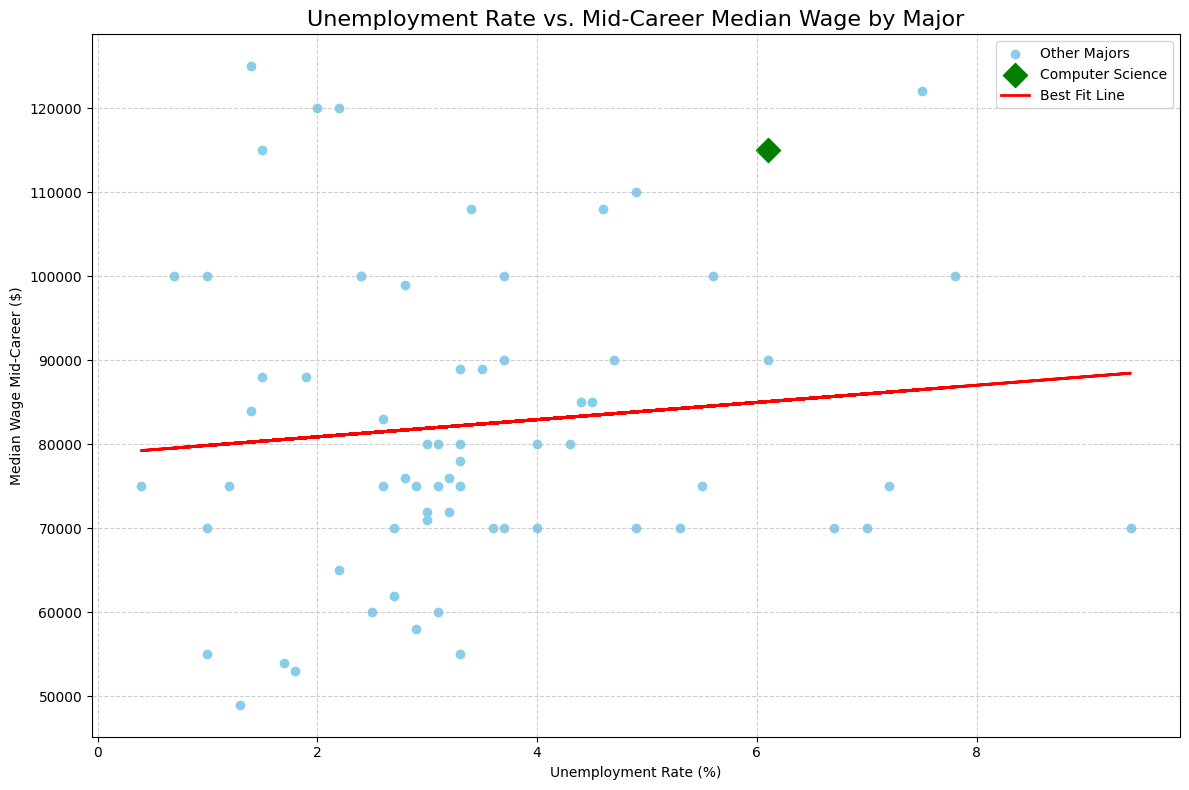

R² = 0.01


In [216]:
#Lets join together unemployment and wages to evaluate the relationship in a scatter plot! 
majors_MWM_UR = pd.read_sql("""SELECT Major, [Unemployment Rate], [Median Wage Mid-Career] FROM majors""", engine)
print(majors_MWM_UR)
#will give us everything from our majors table, now we can mess around however we like!
#Lets do a scatter to see how the risky majors look against the wealthier majors, with a line of best fit to see this correlation
import numpy as np

plt.figure(figsize=(12,8))

#plot all majors
plt.scatter(
    majors_MWM_UR["Unemployment Rate"], 
    majors_MWM_UR["Median Wage Mid-Career"], 
    color="skyblue", label="Other Majors"
)

#Again highlight CS
cs = majors_MWM_UR[majors_MWM_UR["Major"].str.contains("Computer Science", case=False)]
plt.scatter(
    cs["Unemployment Rate"], 
    cs["Median Wage Mid-Career"], 
    color="green", s=150, marker="D", label="Computer Science"
)
x = majors_MWM_UR["Unemployment Rate"]
y = majors_MWM_UR["Median Wage Mid-Career"] 
m, b = np.polyfit(x, y, 1)   #slope, intercept
plt.plot(x, m*x + b, color="red", linewidth=2, label="Best Fit Line")


#Labels
plt.title("Unemployment Rate vs. Mid-Career Median Wage by Major", fontsize=16)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Median Wage Mid-Career ($)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#Calculating correlation coefficient
r = np.corrcoef(x, y)[0, 1]
#From the line of best fit, there seems to be little correlation, but lets print out the correlation coefficient regardless 
print(f"R² = {r**2:.2f}")

                        Major  Unemployment Rate  Median Wage Early Career
0                 Agriculture                1.2                     50000
1   Animal and Plant Sciences                1.0                     43000
2       Environmental Studies                2.6                     46700
3                Architecture                4.3                     52000
4              Ethnic Studies                2.6                     45000
..                        ...                ...                       ...
62          Treatment Therapy                3.1                     46900
63           General Business                3.7                     60000
64                 Accounting                1.9                     60000
65        Business Management                4.0                     55000
66         Business Analytics                2.4                     70000

[67 rows x 3 columns]


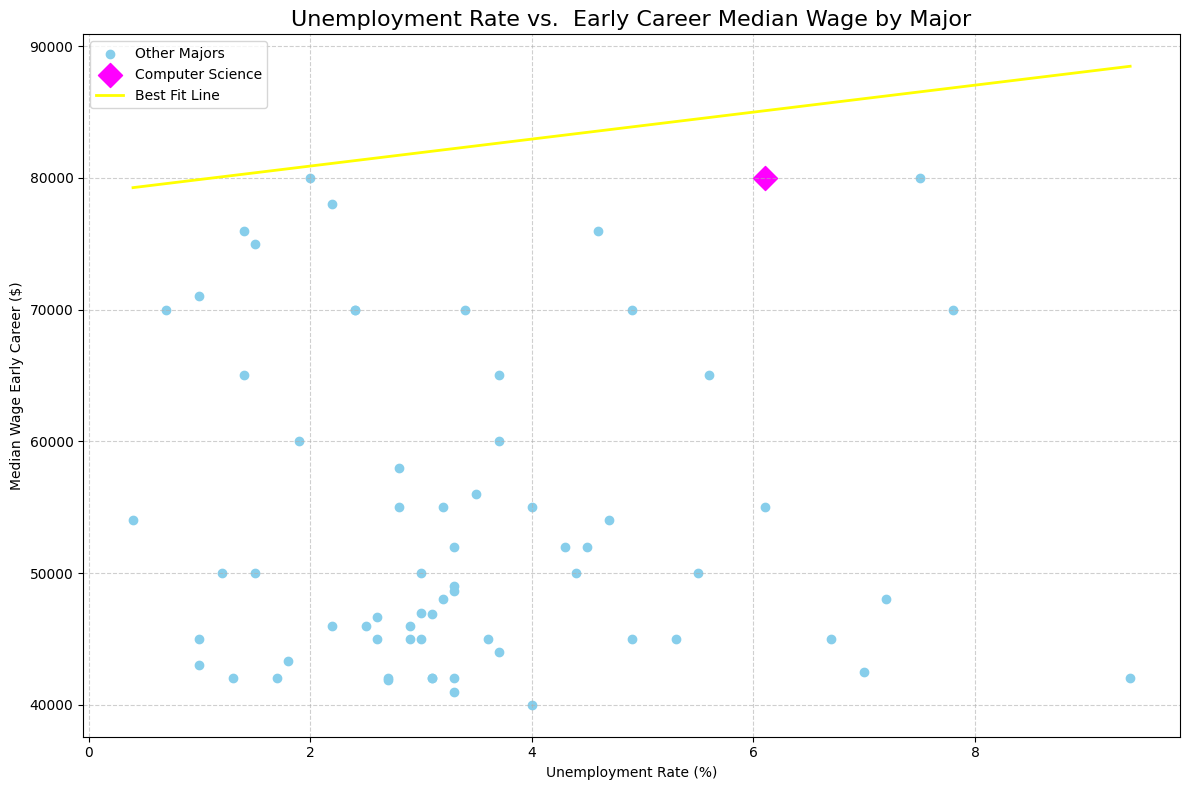

R² = 0.00


In [223]:
#Might as well also look at earnings from early grads to see if that makes a real difference.
#Possible due to the fact the market is quite unstable and the surge of CMSCI students in recent years.

#Easy to grab early grads, just use simple query.

majors_MEM_UR = pd.read_sql("""SELECT Major, [Unemployment Rate], [Median Wage Early Career] FROM majors""", engine)
print(majors_MEM_UR)


plt.figure(figsize=(12,8))

#Scatter but swap with early career grads. 
plt.scatter(
    majors_MEM_UR["Unemployment Rate"], 
    majors_MEM_UR["Median Wage Early Career"], 
    color="skyblue", label="Other Majors"
)

#Highlight CS once again, magenta this time for fun. Sort by unemployment rate for the x axis.
cs = majors_MEM_UR[majors_MEM_UR["Major"].str.contains("Computer Science", case=False)]
plt.scatter(
    cs["Unemployment Rate"], 
    cs["Median Wage Early Career"], 
    color="magenta", s=150, marker="D", label="Computer Science"
)
x = majors_MEM_UR["Unemployment Rate"]
y = majors_MEM_UR["Median Wage Early Career"] 
x_sorted = np.sort(x)
plt.plot(x_sorted, m*x_sorted + b, color="yellow", linewidth=2, label="Best Fit Line")



#Make graph look amazing
plt.title("Unemployment Rate vs.  Early Career Median Wage by Major", fontsize=16)
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Median Wage Early Career ($)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

#Calculating correlation coefficient
r = np.corrcoef(x_sorted, y)[0,1]

#From the line of best fit, there seems to be little correlation, but lets print out the correlation coefficient regardless 
print(f"R² = {r**2:.2f}")

## Early-Career Outcomes  

To extend the analysis, we also examine **early-career earnings** and whether they show a stronger relationship with unemployment rates compared to mid-career wages.  

The results, however, are strikingly similar. The **line of best fit remains nearly horizontal**, and the **R² value once again hovers close to 0**, suggesting **no meaningful correlation** between early-career wages and unemployment rates across majors.  

For Computer Science, the story remains the same: **higher unemployment risk**, but with **solid salary potential even early in a career**. This underscores the volatility of the job market and how the **recent surge in CS graduates** may contribute to the elevated unemployment rate, without necessarily suppressing wages.  However my personal belief is that there was a massive surge in unemployment in most industries due to the pandemic, as we will come to see. But even more so for computer science due to folks being stuck in their homes, which I believed massively contributed to **computer science** being such risky industry.


Now lets evaluate our other dataset and determine whether the national unemployment rate amongst all citizens has been skyrocketing recentely, and where **computer science** stands next to it.

In [224]:
#Let's ealuate the national unemployment rate from the FRED
fred["Monthly"] = pd.to_datetime(fred["Monthly"])
print(fred)

      Monthly  Unemployment Rate
0  2019-01-01                4.0
1  2019-02-01                3.8
2  2019-03-01                3.8
3  2019-04-01                3.7
4  2019-05-01                3.6
..        ...                ...
75 2025-04-01                4.2
76 2025-05-01                4.2
77 2025-06-01                4.1
78 2025-07-01                4.2
79 2025-08-01                4.3

[80 rows x 2 columns]


# Lets Take a Look at the National Unemployment!
Just looking at 2020 it is easy to tell the following graph will have an absurd outlying year due to the pandemic. To clearly show this I will implement a **red line** so you don't miss it (don't worry... I don't think you'll need it)! I do this through an axvline which represents a vertical line on the x axis right at the peak of unemployment. 

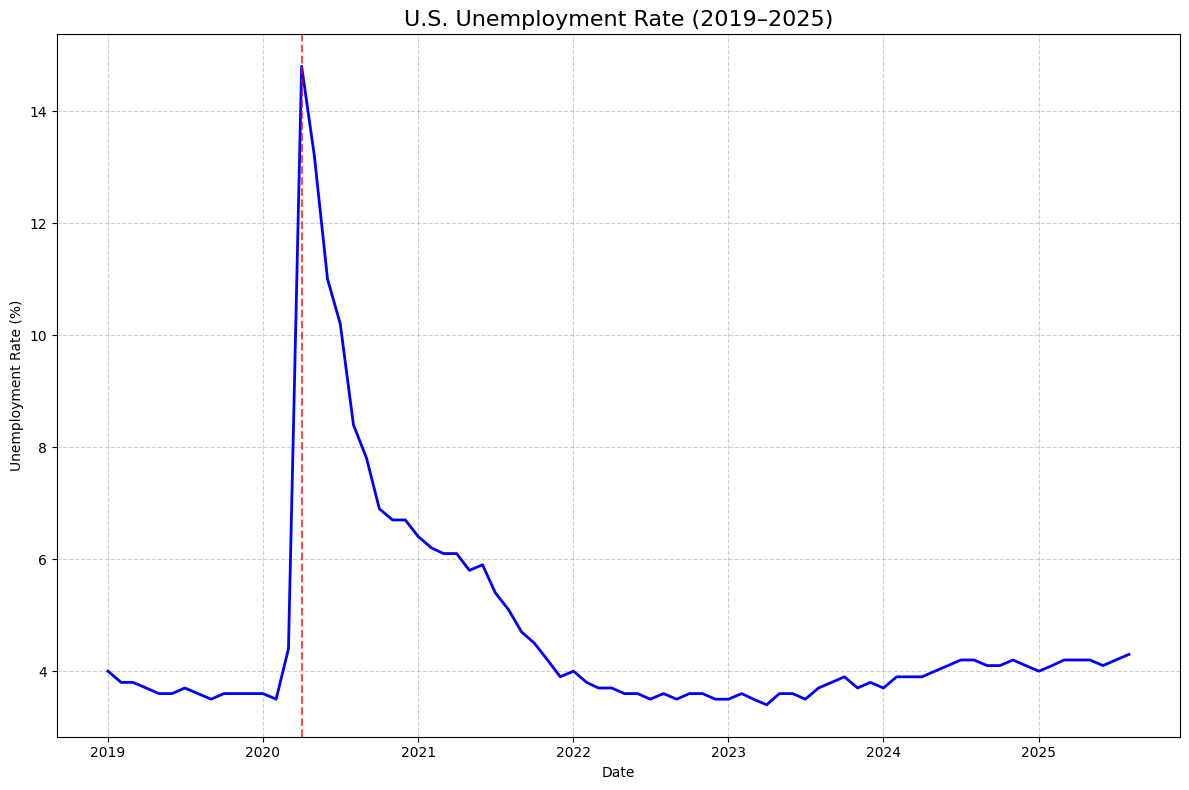

In [200]:
plt.figure(figsize=(12,8))

plt.plot(fred["Monthly"], fred["Unemployment Rate"], color = "blue", linewidth = 2)

#Plotting unemployment, pretty normal barring the one crazy spike from COVID-19
#Can highlight this crazy period like:

plt.axvline(pd.to_datetime("2020-04-01"), color="red", linestyle="--", alpha=0.7)


plt.title("U.S. Unemployment Rate (2019–2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


The above graph depicts the typical unemployment rate, however nicely shows how catastrophic **COVID-19** was on the country's employment, as the pandemic forced massive layoffs. To offset this year, let's use a **SQL query** to manually select only dates before 2022, to better view what unemployment looks like normally. We will continue to load these into pandas data frames.

In [225]:
query = """
SELECT Monthly, [Unemployment Rate]
FROM fred
WHERE DATE(Monthly) >= '2022-01-01'
ORDER BY Monthly
"""
fred_after2022 = pd.read_sql(query, engine)
print(fred_after2022)
#We now have a stable selection of just the post COVID unemployment rate that we can now use to grasp a better understanding of the unemployment rate normally.


       Monthly  Unemployment Rate
0   2022-01-01                4.0
1   2022-02-01                3.8
2   2022-03-01                3.7
3   2022-04-01                3.7
4   2022-05-01                3.6
5   2022-06-01                3.6
6   2022-07-01                3.5
7   2022-08-01                3.6
8   2022-09-01                3.5
9   2022-10-01                3.6
10  2022-11-01                3.6
11  2022-12-01                3.5
12  2023-01-01                3.5
13  2023-02-01                3.6
14  2023-03-01                3.5
15  2023-04-01                3.4
16  2023-05-01                3.6
17  2023-06-01                3.6
18  2023-07-01                3.5
19  2023-08-01                3.7
20  2023-09-01                3.8
21  2023-10-01                3.9
22  2023-11-01                3.7
23  2023-12-01                3.8
24  2024-01-01                3.7
25  2024-02-01                3.9
26  2024-03-01                3.9
27  2024-04-01                3.9
28  2024-05-01

Perfect lets plot this data and see what we get.

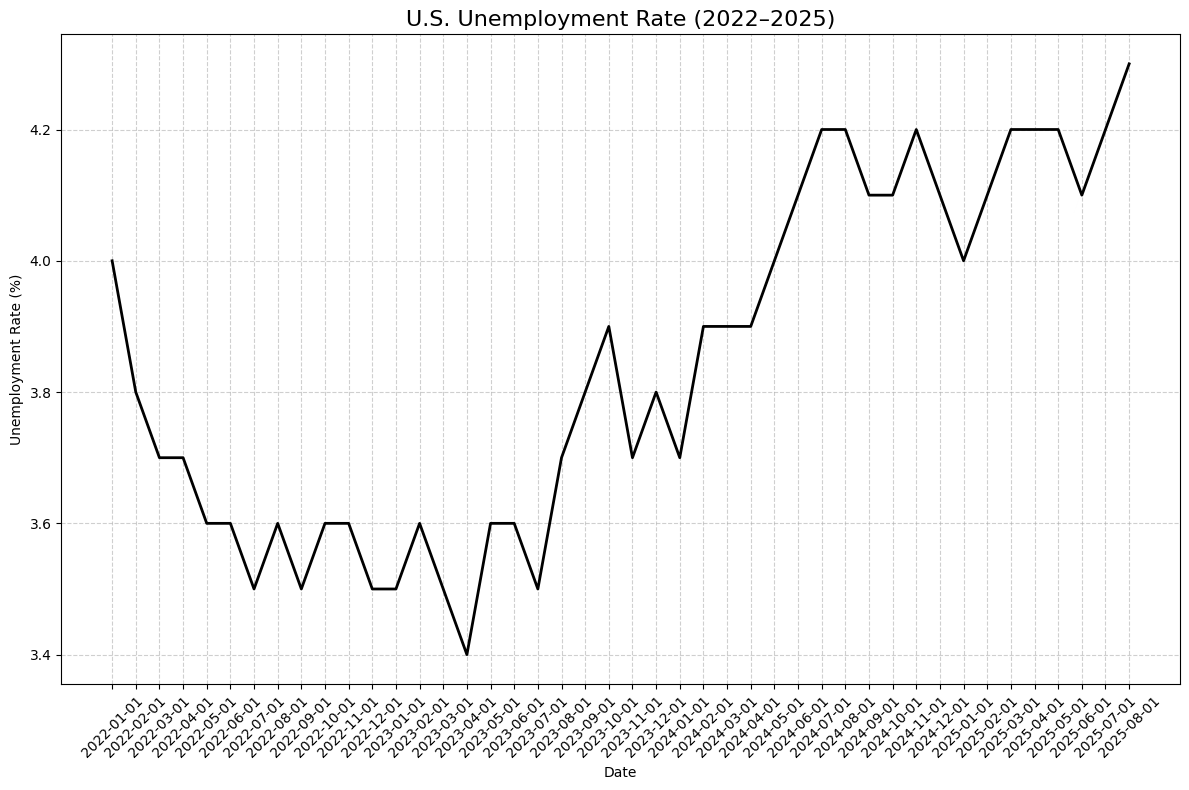

In [ ]:
#We can then plot this data from 
plt.figure(figsize=(12,8))

plt.plot(fred_after2022["Monthly"], fred_after2022["Unemployment Rate"], 
         color="black", linewidth=2)

plt.title("U.S. Unemployment Rate (2022–2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



## National Unemployment Rate (2022–2025)  

After filtering out the pandemic shock years, we can observe the U.S. unemployment rate from 2022 onward.  

The plot shows that unemployment has been **steadily increasing in recent years**, reflecting a gradual slowdown in the labor market after recovering from the pandemic. However, it is still nowhere near the catastrophic spike we saw in 2020 during the height of COVID-19.  

This comparison reinforces two key takeaways:  
- **Current unemployment growth is gradual but concerning**, indicating potential economic instability.  
- **The pandemic period was truly unprecedented**, and its impact stands out as a historical outlier rather than part of the normal labor cycle.  


Lets also observe the average unemployment per year, using a query to compute the average rate into a new column where we group by the year.
They key part to the following query is **strftime**, which essentially is a sqlite function that formats dates, and by specifying **%Y, Monthly** we extract only the year, using **GROUP BY** and **AVG** to easily compute one average rate per year.

   Year   AvgRate
0  2019  3.675000
1  2020  8.100000
2  2021  5.358333
3  2022  3.641667
4  2023  3.633333
5  2024  4.033333
6  2025  4.162500


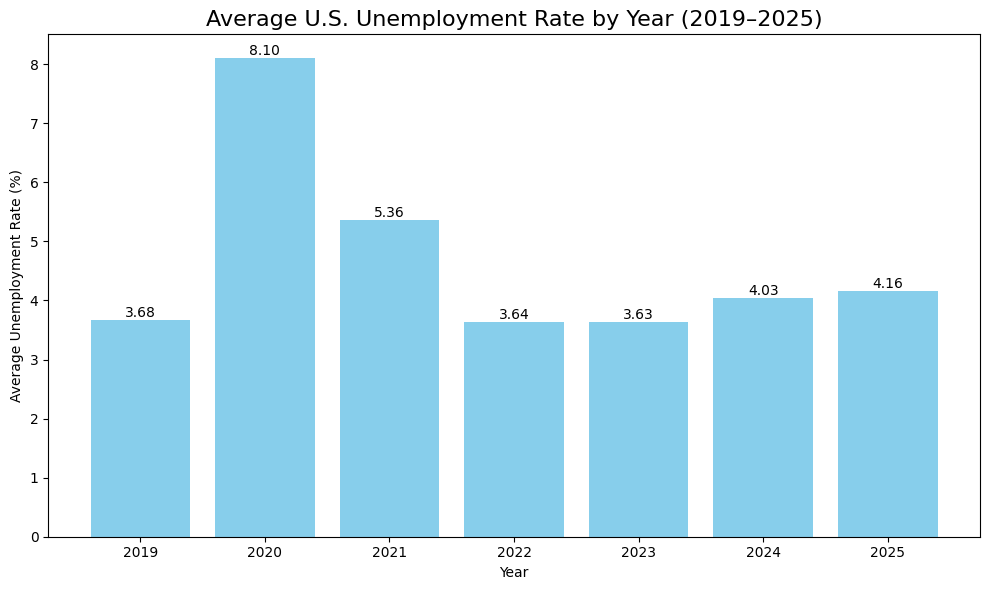

In [227]:
query = """
SELECT strftime('%Y', Monthly) AS Year,
       AVG([Unemployment Rate]) AS AvgRate
FROM fred
GROUP BY Year
ORDER BY Year
"""
fred_yearly = pd.read_sql(query, engine)
print(fred_yearly)


plt.figure(figsize=(10,6))

#Bar chart formatting to two dec. Notice what we are grabbing from our two newly derived columns.
bars = plt.bar(fred_yearly["Year"], fred_yearly["AvgRate"], color="skyblue")
plt.bar_label(bars, fmt="%.2f")


plt.title("Average U.S. Unemployment Rate by Year (2019–2025)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Average Unemployment Rate (%)")

plt.tight_layout()
plt.show()



## Visualizing Yearly Average Unemployment Rates  

  Disregarding 2020 and 2021, 2025 has a whopping 0.5% increase in national unemployment, which might not sound like much but 0.5% for 330 million people is A LOT of people.


### Comparing Major Unemployment Rates to the National Average

The following two graphs start getting more complex with SQL, using **joins** to directly compare the unemployment rate for each major to the **national unemployment rate**. To do this, we calculate the difference between each major’s unemployment rate and the national average in 2025.

Here’s how it works:


**strftime('%Y', Monthly)** extracts just the year from the Monthly date column in the fred table. Then the  WHERE clause restricts rows to the year 2025. This works by combining all the months and extracting the average into an alias like the previous queries. Following that we use a **CROSS JOIN**. 
Since the subquery returns only one row, a cross join attaches that single value (AvgRate) to every row of the majors table.
This gives us access to both the unemployment rate of each major (m.[Unemployment Rate]) and the 2025 national average (f.AvgRate) at the same time.


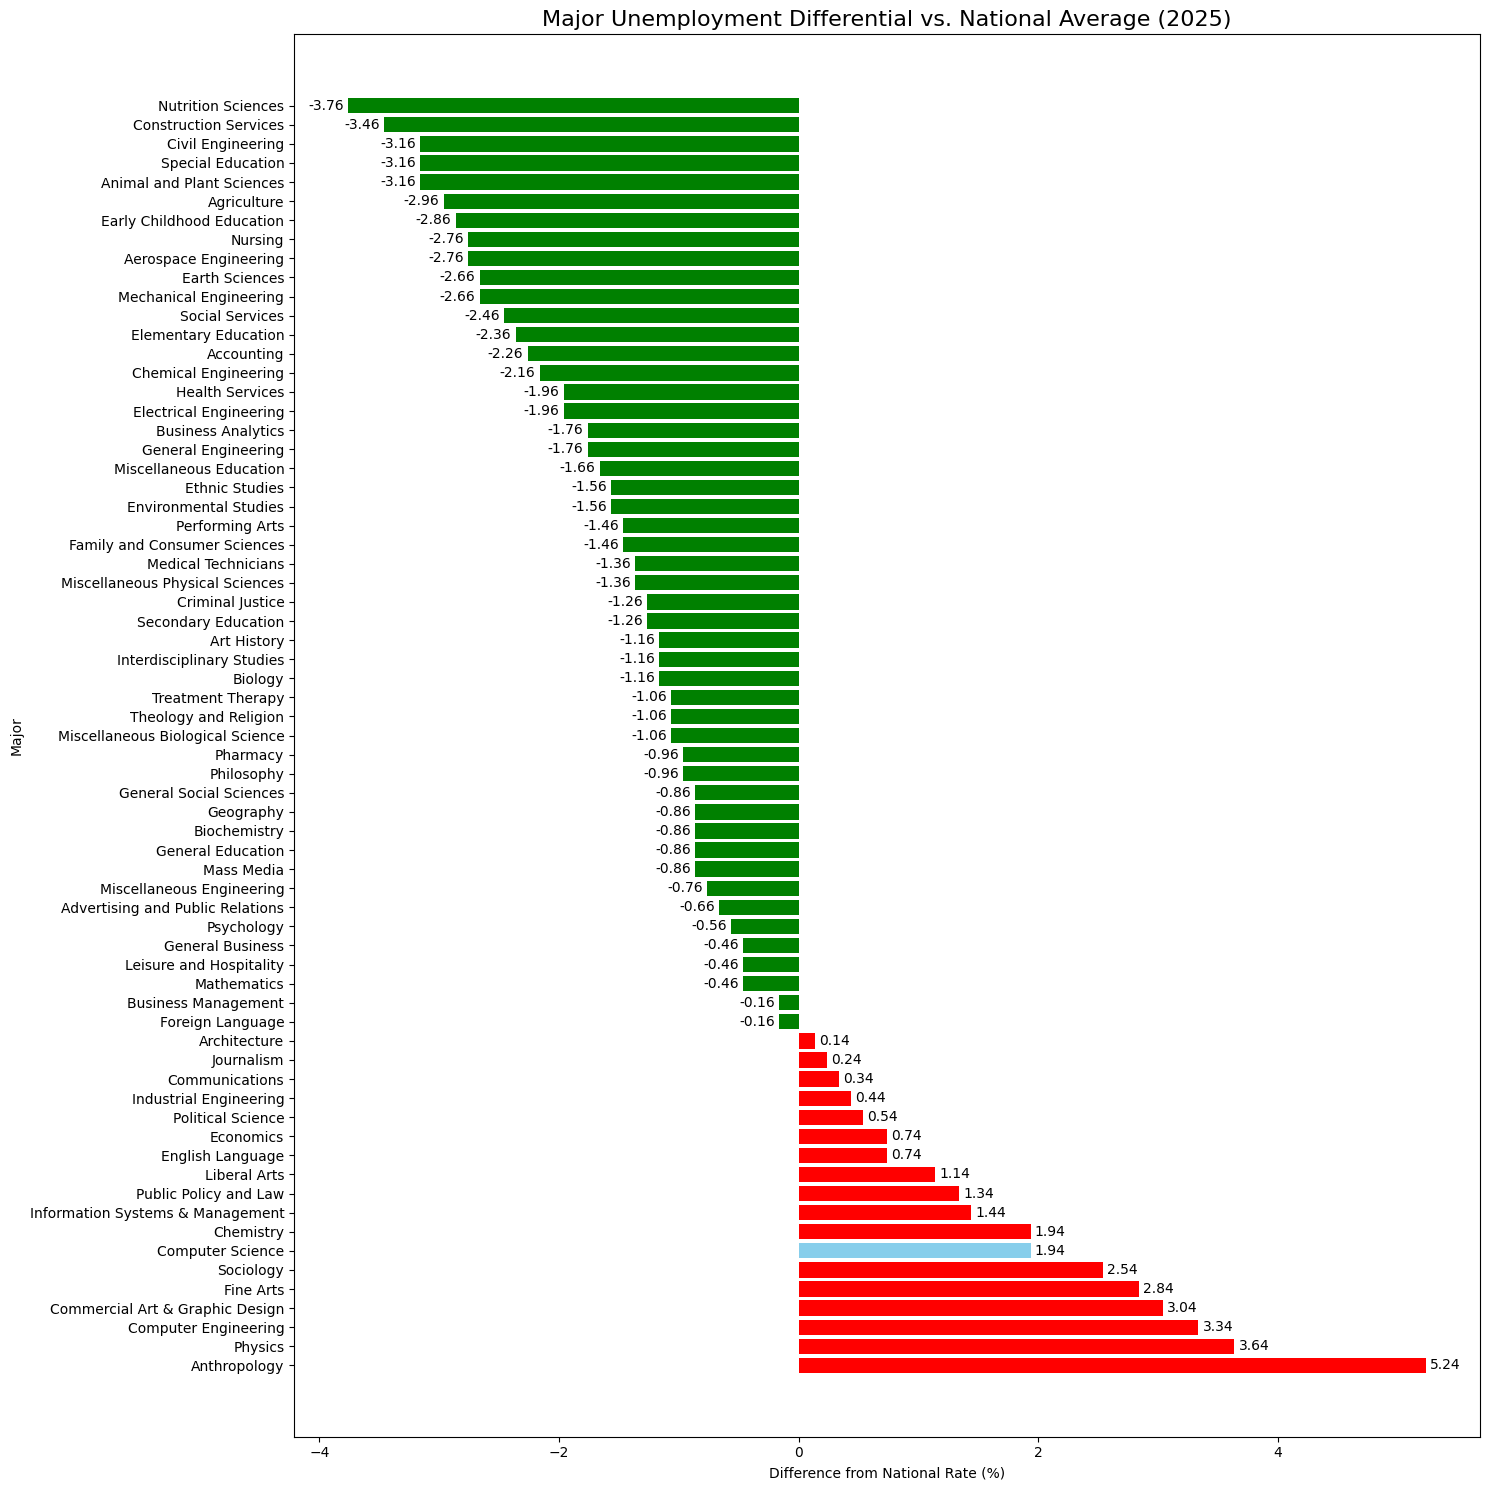

In [204]:

#Query already gives Diff_From_National in descending order
query = """
SELECT 
    m.Major,
    m.[Unemployment Rate],
    m.[Unemployment Rate] - f.AvgRate AS Diff_From_National
FROM majors m
CROSS JOIN (
    SELECT AVG([Unemployment Rate]) AS AvgRate
    FROM fred
    WHERE strftime('%Y', Monthly) = '2025'
) f
ORDER BY Diff_From_National DESC;
"""

DIFFERENTIAL_2025 = pd.read_sql(query, engine)

plt.figure(figsize=(15,15))

#Build color list row by row to distinguish computer science
colors = []
for major, diff in zip(DIFFERENTIAL_2025["Major"], DIFFERENTIAL_2025["Diff_From_National"]):
    if major == "Computer Science":
        colors.append("skyblue")  #highlight CS
    elif diff > 0:
        colors.append("red")      #worse than national
    else:
        colors.append("green")    #better than national

bars = plt.barh(
    DIFFERENTIAL_2025["Major"], 
    DIFFERENTIAL_2025["Diff_From_National"], 
    color=colors
)

#Add labels
plt.bar_label(bars, fmt="%.2f", padding=3)

#Titles and labels
plt.title("Major Unemployment Differential vs. National Average (2025)", fontsize=16)
plt.xlabel("Difference from National Rate (%)")
plt.ylabel("Major")

plt.tight_layout()
plt.show()


### Visualizing Major Unemployment Differentials in 2025

After computing the difference between each major’s unemployment rate and the 2025 national average, we can visualize the results in a horizontal bar chart. To make the chart easier to read, we color–code the bars:

- **Sky blue** for Computer Science (our focus major).  
- **Red** for majors with higher unemployment than the national average.  
- **Green** for majors with lower unemployment than the national average.  

To achieve this, we loop through both the list of majors and their corresponding differences using Python’s `zip` function:

```python
colors = []
for major, diff in zip(DIFFERENTIAL_2025["Major"], DIFFERENTIAL_2025["Diff_From_National"]):
    if major == "Computer Science":
        colors.append("skyblue")  # highlight CS
    elif diff > 0:
        colors.append("red")      # worse than national
    else:
        colors.append("green")    # better than national


The graph demonstrates how ALL majors compare to the national average of unemployment, with **computer science** unfortunately near the bottom with a near *2%* increase from the national average.

# Comparing Computer Science to other majors
Finally I would love to see how my major matches up against the other engineering majors as well as some buisness ones so lets setup a query for that as well.
The only major difference in this query compared to the last is where we use the % to encapsulate strings:

WHERE m.Major LIKE '%Engineering%'
   OR m.Major LIKE '%Business%'
   OR m.Major LIKE '%Computer%'
 
and majors we want to compare to **computer science**. For this I deliberately picked **engineering majors, buisness majors, and other computer majors**. 

Finally, we sort the majors from the largest positive difference (worst relative to national) to the most negative (best relative to national).


                        Major  Unemployment Rate  Diff_From_National
0        Computer Engineering                7.5              3.3375
1            Computer Science                6.1              1.9375
2      Industrial Engineering                4.6              0.4375
3         Business Management                4.0             -0.1625
4            General Business                3.7             -0.4625
5   Miscellaneous Engineering                3.4             -0.7625
6         General Engineering                2.4             -1.7625
7          Business Analytics                2.4             -1.7625
8      Electrical Engineering                2.2             -1.9625
9        Chemical Engineering                2.0             -2.1625
10     Mechanical Engineering                1.5             -2.6625
11      Aerospace Engineering                1.4             -2.7625
12          Civil Engineering                1.0             -3.1625


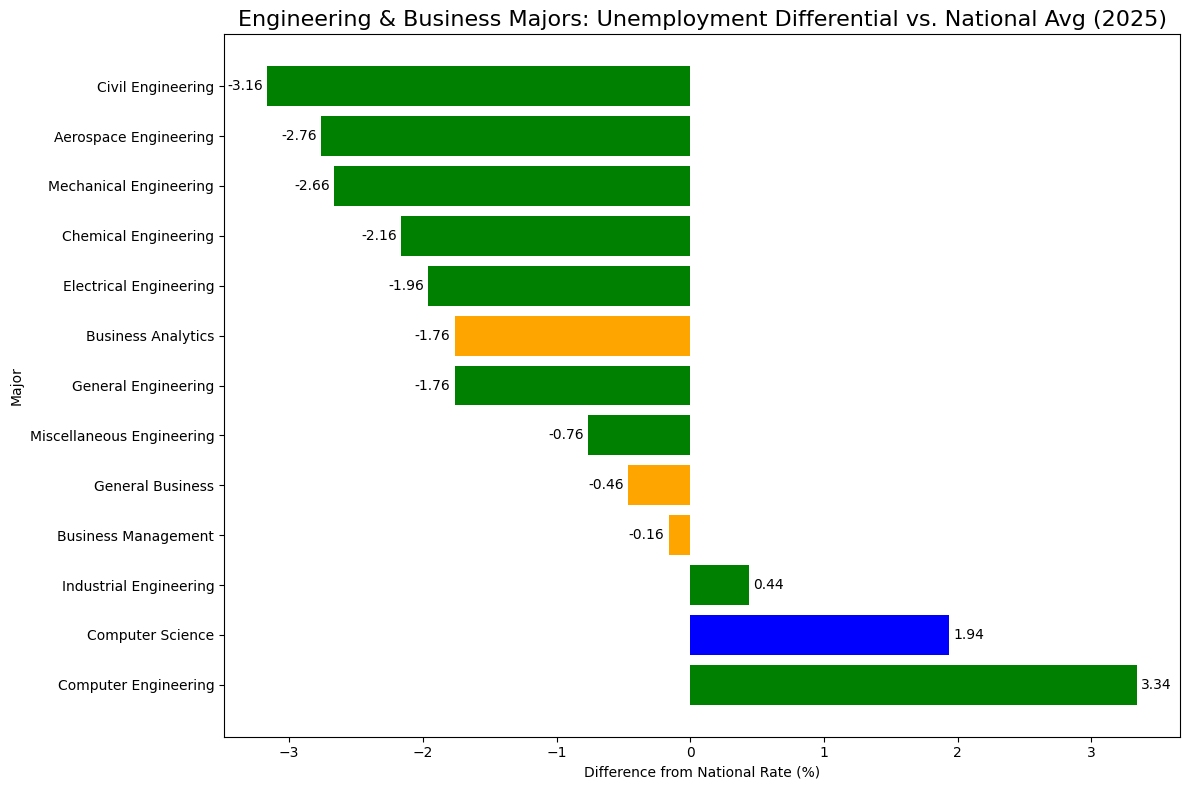

In [ ]:

query = """
SELECT 
    m.Major,
    m.[Unemployment Rate],
    m.[Unemployment Rate] - (
        SELECT AVG([Unemployment Rate])
        FROM fred
        WHERE strftime('%Y', Monthly) = '2025'
    ) AS Diff_From_National
FROM majors m
WHERE m.Major LIKE '%Engineering%'
   OR m.Major LIKE '%Business%'
   OR m.Major LIKE '%Computer%'
ORDER BY Diff_From_National DESC;
"""

eng_bus = pd.read_sql(query, engine)
print(eng_bus)

plt.figure(figsize=(12,8))

# Color scheme: highlight CS or Eng vs Bus
colors = [
    "blue" if "Computer Science" in major else
    "orange" if "Business" in major else
    "green"
    for major in eng_bus["Major"]
]

bars = plt.barh(
    eng_bus["Major"],
    eng_bus["Diff_From_National"],
    color=colors
)

#Add labels on each bar
plt.bar_label(bars, fmt="%.2f", padding=3)

#Titles and labels
plt.title("Engineering & Business Majors: Unemployment Differential vs. National Avg (2025)", fontsize=16)
plt.xlabel("Difference from National Rate (%)")
plt.ylabel("Major")

plt.tight_layout()
plt.show()



The results show of course that **Computer Science** in second place behind only **Computer Engineering** for having the highest unemployment rate compared to the national average. Once again, ouch...

# **Conclusions**:

## Final Analysis & Key Takeaways  

In this project, we combined **SQL, Pandas, Matplotlib, and Python** to explore how different college majors compare in terms of unemployment and wages, and to benchmark those outcomes against national unemployment data.  

- **SQL** allowed us to filter, group, and join the data (e.g., calculating yearly averages, comparing majors against the 2025 national average).  
- **Pandas** made it possible to transform and clean the datasets, such as converting wage columns from strings with commas into usable integers.  
- **Matplotlib** provided clear and flexible visualizations — bar charts, scatter plots, and trend lines — that revealed insights at a glance.  
- **Python** tied everything together, letting us automate analysis steps, compute regression lines, and calculate statistics like correlation coefficients.  

### What the Data Shows  
- **Computer Science is both risky and highly profitable.**  
  - The unemployment rate for Computer Science majors is **6.1%**, significantly higher than the **2025 national average of 4.16%**.  
  - However, mid-career wages for Computer Science majors reach **$115,000**, placing it among the top-paying fields. This shows a classic *high-risk, high-reward* pattern.  

- **National vs. Major-Level Comparison:**  
  - By subtracting major-specific unemployment rates from the national average, we clearly saw that Computer Science is underperforming relative to the broader workforce, even compared to other engineering and business fields.  

- **Impact of COVID-19:**  
  - The data confirms just how catastrophic COVID-19 was on employment. The national unemployment rate spiked to an **average of 8.10% in 2020**, dwarfing normal fluctuations in other years. This shock is visually striking in the time-series plot and remains unmatched in recent history.  


Overall, this analysis shows the **dual nature of Computer Science as a career path**:  
- It carries a higher risk of unemployment than many other majors, reflecting the volatility and competitiveness of the tech industry.  
- Yet, the payoff is significant for those who secure employment, with wages that far exceed the median across all fields.  

By leveraging the strengths of SQL for structured queries, Pandas for data manipulation, and Matplotlib for visualization, this project demonstrates how technical tools can be integrated to tell a **cohesive and evidence-driven story** about education, economics, and career risk.  
